In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import pickle
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

font = {
    #'family' : 'normal',
    #'weight' : 'bold',
    'size'   : 22
}
matplotlib.rc('font', **font)

from pscan import pscan_view, organize_pscans

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
mpiout_path = '/srv/cluster/mini_gillespiem/.simulators/keep/run.pkl'
with open(mpiout_path, 'rb') as f:
    n_processing = 1
    locations, data = pickle.loads(f.read())
    pspace, pscans = organize_pscans(locations, data, n_processing)

In [ ]:
pscan = pscans[0]
subspace = {
    #'kappa_T': 0.0000001, 
    #'kappa_T': 0, 
    'kappa_I': 0.1, 
    #'kappa_M': 0.5, 
    #'lambda_i': 20, 
    'phi': 10.0, 
}
targets = ('time', 'T_free', 'I')

selection = pscan_view(pscan, subspace, targets)
selection.shape, selection.columns

trajectory = 0
target = 'T_free'

time_selection = selection.loc[selection['Target'] == 'time'].reset_index()
target_selection = selection.loc[selection['Target'] == target].reset_index()

n_fig = target_selection.shape[0]
f, axes = plt.subplots(n_fig, 1, figsize=(12, 2 * n_fig))
f.subplots_adjust(wspace=0.8, hspace=0.8)
for (t, time), (l, location), ax in zip(time_selection.iterrows(), target_selection.iterrows(), axes):
    subspace = location[pspace.columns]
    subspace = ', '.join(('%s: %s' % (i, j)) for i, j in zip(subspace.index, subspace.values))
    ax.set_title('location: %s' % subspace)
    counts = location['Batch'][trajectory, :]
    time = time['Batch'][trajectory, :]
    ax.plot(time, counts, linewidth=3)
    events = location['Events']
    if events and sum([len(e) for e in events]):
        parameters = location['Parameters']
        high, low = parameters['high'], parameters['low']
        medium = (high + low) / 2.0
        ax.plot([time[0] - 1, time[-1] + 1], [low, low], color='k', ls='--')
        ax.plot([time[0] - 1, time[-1] + 1], [medium, medium], color='k', ls='--')
        ax.plot([time[0] - 1, time[-1] + 1], [high, high], color='k', ls='--')
        for i, j in events[trajectory]:
            ax.plot([time[i], time[j]], [medium, medium], color='r', lw=5, marker='s')
    ax.set_xlim((0.2 * time.shape[0], min(0.2 * time.shape[0] + 1000, time[-1])))

In [ ]:
pscan = pscans[0]
subspace = {
    #'kappa_T': 0.0000001, 
    #'kappa_T': 0, 
    'kappa_I': 0.1, 
    #'kappa_M': 1.0, 
    #'lambda_i': 5, 
    'phi': 100.0, 
}
targets = ('time', 'T_free', 'I')

selection = pscan_view(pscan, subspace, targets)
selection.shape, selection.columns

trajectory = 0
target = 'T_free'

time_selection = selection.loc[selection['Target'] == 'time'].reset_index()
target_selection = selection.loc[selection['Target'] == target].reset_index()

x = 'eta_p'
ys = [['Toxic Probability'], ['Mean Event Duration'], ['Event Count']]

#print(target_selection[x])

n = len(ys)
f, axes = plt.subplots(n, 1, figsize=(12, n * 6))
for ax, targets in zip(axes, ys):
    target_selection.plot(x=x, y=targets, ax=ax)
    ax.set_title('%s Versus %s' % (', '.join(targets), x))
    ax.set_xlabel(x)
    ax.set_ylabel(', '.join(targets))

In [20]:
def heat(ax, selection, xaxis, yaxis, zaxis):
    x = selection[xaxis].values
    y = selection[yaxis].values
    z = selection[zaxis].values

    xs, ys = np.unique(x), np.unique(y)
    X, Y = np.meshgrid(xs, ys)
    Z = z.reshape(xs.shape[0], ys.shape[0]).transpose()
    
    img = ax.pcolormesh(X, Y, Z)
    f.colorbar(img, ax=ax)
    ax.set_xlabel(xaxis)
    ax.set_ylabel(yaxis)
    #ax.set_title(zaxis)

    ax.set_xscale('log')
    ax.set_yscale('linear')
    
    return ax

# The Setup

* One TA module (MazEF dynamics)
* One inducible protein (CFP)
* Two proteolytic pathways (ClpXP, ClpAP, Lon)


* TA module is targeted to both pathways mostly symmetrically
* Inducible protein is tunably targeted to both pathways


* Aim to suggest a picture by which targeting CFP to one pathway or another may increase or decrease persistence


# Punchlines:
Whether a tag such as LAA is present is important to force proteolytic queueing with respect to module components. Such tags can asymmetrically target module components, thus asymmetrically affecting toxic state probability with respect to particular proteolytic pathways. Asymmetry of module component proteolytic affinity can drastically affect how this competition influences persistence despite a module component (e.g. toxin) constituting only a small fraction of proteolytic load. If competition is sufficient to interfere with antitoxin or complex degradation, it can prevent persistence entirely by ensuring free antitoxin is always available to neutralize free toxin. The threshold of inducible protein (e.g. CFP) affinity which either increases or decreases persistence is likely dependent on production rate of the protein (i.e. can be intentionally modulated with an inducer such as IPTG).

# Interpreting Parameters

#### eta_p
* eta_p modulates to which proteolytic pathway CFP is targeted.
* eta_p represents the asymmetric targeting associated with one degradation tag over another.
* When eta_p = 0.0, all CFP traffic is targeted through pathway 2.
* When eta_p = 1.0, all CFP traffic is targeted through pathway 1.
* When eta_p = 0.5, all CFP traffic is equally targeted to both pathways.

#### kappa_I
* kappa_I modulate how strongly CFP is targeted for proteolysis.
* Without LAA, CFP is less targeted than toxin.
* With LAA, CFP is more targeted.
* kappa_I represents this difference in a continuous way.

#### phi
* When phi = 1, all toxin traffic is equally targeted to both pathways; the system should be symmetric with respect to eta_p.
* When phi = 10, all toxin traffic is targeted 10 fold more toward pathway 2 than pathway 1.
* When phi = 100, all toxin traffic is targeted 100 fold more toward pathway 2 than pathway 1.
* phi < 1 or phi > 1 represents an asymmetry in how toxin is degraded.
* Even with phi = 100, complex is is 100 fold more targeted for protoelysis.


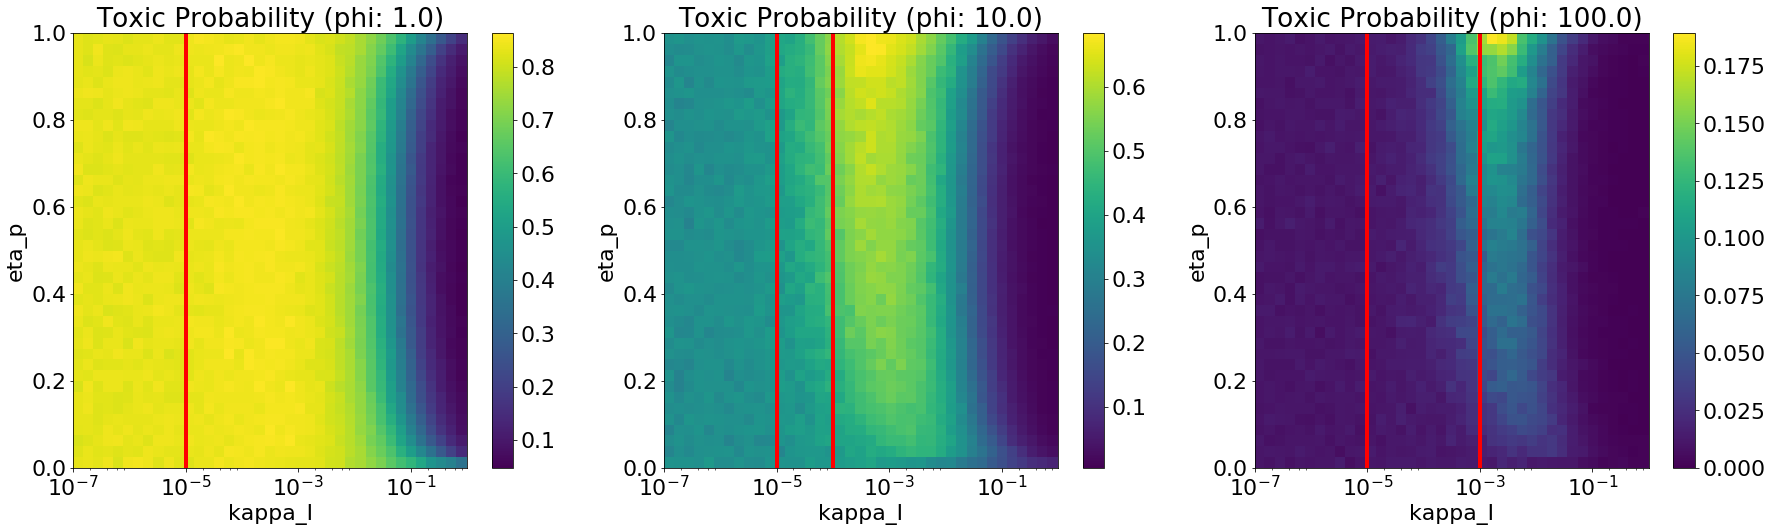

In [23]:
xaxis = 'kappa_I'
yaxis = 'eta_p'
zaxis = 'Toxic Probability'

phi_values = (1, 10, 100)

n_fig = len(phi_values)
f, axes = plt.subplots(1, n_fig * 1, figsize=(n_fig * 10, 8))
if n_fig == 1:
    axes = [axes]

for phi, ax in zip(phi_values, axes):
    kappa_T_1 = 0.00001
    kappa_T_2 = phi * kappa_T_1

    pscan = pscans[0]
    subspace = {'phi': phi}
    targets = ('time', 'T_free', 'I')
    target = 'T_free'

    selection = pscan_view(pscan, subspace, targets)
    selection = selection.loc[selection['Target'] == target].reset_index()
    selection.shape, selection.columns

    ax = heat(ax, selection, xaxis, yaxis, zaxis)
    ax.set_title('%s (phi: %0.1f)' % (zaxis, phi))

    ax.plot([kappa_T_1, kappa_T_1], [0, 1], lw=4, color='r')
    ax.plot([kappa_T_2, kappa_T_2], [0, 1], lw=4, color='r')